# Cluster splitting schemes

This is a temporary notebook, in which we investigate all the methods to split the clusters. More precisely, we look for:

- Metrics telling us wether or not we should split a cluster
- Metrics to tell us in how much clusters we should split it
- Methods to split the clusters

We will do a grid search to look for the splitting algorithms with the best overall performance, without worrying yet about explanations or interpreations. This will allow us to be way more efficient.



Regarding the methods to split the clusters, we distinguish:
- Methods which does not need an a priori number of clusters
- Methods which needs an a priori number of clusters
- Methods to split the clusters in two, which we can integrate into Diego's binary-tree like cluster splitting scheme.


We begin with the methods who does not need an a priori number of clusters. These can be:
- Methods that works on graphs, in which case we should decide wether we use the NLFA/filtered graph, the NLFA graph or dissimilarity graph.
- Methods that works on features, in which case we can use either the image representation, the HOG, or other features.
- Methods that works on metric spaces, allowing us to apply the registration algorithm when creating the clusters, to get more informative metrics.

One of the biggest issues when doing clustering is to find an informative metric. In fact, when using high-dimensional vectors like the raw image pixels, or a precise HOG, the features all trend to be the same distance from one another, and the distances become less informative. Our assumption is that the extracted features lies on a low-dimensionnality manifold.

# Imports & Data Loading

We load all the data into two dataframes:
- patches_df: all the info about all characters in the document
- repr_df: The representative of the clusters, i.e. the character with the biggest number of connections
- happax_df: the subset of patches_df containing all happax

We also load the graph we constructed during the clustering.

In [1]:
import sys
import os
from pathlib import Path
from hydra import initialize, compose
initialize(config_path="../confs", job_name="notebook")

sys.path.append(os.path.abspath("../src"))
# We change the working directory to the root of the project
# Run this only once
root_path = Path.cwd().parent
os.chdir(root_path)
sys.path.append(root_path / "src")


from src.utils import torch_to_pil
from src.utils import connectedComponent
from src.patch_processing.patch_extraction import extract_patches

from notebook_utils.descriptor import compute_hog, visualize_hog
from notebook_utils.deepseek import get_character_meaning, get_character_meanings_ordered, display_character_or_error, display_character_with_meaning

from einops import rearrange
import torch

import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

from PIL import Image

import networkx as nx
import pickle

from notebook_utils.parquet_utils import load_dataframe, save_dataframe

/tmp/ipykernel_10137/2615729850.py:5: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../confs", job_name="notebook")
/home/mathis/anaconda3/envs/projetOCR/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
output_path = Path("outputs/clustering_results_full")

patches_df = load_dataframe(output_path / 'clustered_patches')
repr_df = load_dataframe(output_path / 'filtered_patches')
graph = pickle.load(open(output_path / 'graph.gpickle', mode='rb'))

features = np.stack(patches_df['histogram'])
features = features.reshape(len(features), -1)
patches_df['histogram'] = list(features)
membership = patches_df['membership']

value, count = np.unique(membership, return_counts=True)
happax_classes = value[count == 1]

happax_df = patches_df[patches_df['membership'].isin(happax_classes)]

Loading column: bin_patch
Loading column: img_patch
Loading column: page
Loading column: file
Loading column: left
Loading column: top
Loading column: width
Loading column: height
Loading column: label
Loading column: page_skew
Loading column: reading_order
Loading column: svg
Loading column: unc_qwen_single
Loading column: char_qwen_single
Loading column: histogram
Loading column: membership
Loading column: degree_centrality
Loading column: best_hog_config
Loading column: best_cell_size
Loading column: best_grdt_sigma
Loading column: best_num_bins
✓ Loaded from outputs/clustering_results_full/clustered_patches
Loading column: bin_patch
Loading column: img_patch


## Renderers & Source imports

**Reminder**: renderers are the objects we use to convert the SVGs (``̀̀`patches_df['svg']``̀̀`) into plain pixels.\
**featureMatching** is the class to compute the NLFA & dissimilarities.

In [ ]:
from src.patch_processing.hog import HOG
from src.patch_processing.renderer import Renderer
from src.patch_processing.params import HOGParameters
from src.clustering.feature_matching import featureMatching
from src.clustering.params import featureMatchingParameters


renderer = Renderer(
    scale=1.0,
    dpi=256,
    bin_thresh=0.5,
    pad_to_multiple=24,
    svg_imgs=patches_df['svg']
)


canvas_dims = renderer.canvas_dims
barycenters = renderer.barycenters

fMParams = featureMatchingParameters(metric="L2", partial_output=False)
featureMatcher = featureMatching(fMParams)

Rendering: 100%|██████████| 13517/13517 [00:49<00:00, 274.76img/s]


_________
## Computing metrics between registered images

We investigate successively how:
- a) to compute the metrics between two images using our class
- b) much time does the alignment step take depending on the inverse compositional algorithm parameters and the renderer
- c) much time does every step of computing the distances actually take
- d) long does it take to compute the metrics inside one given cluster, depending on its size
- e) much time it takes to compute the metrics between some patch inside the trash and all representatives
- f) to be lazy and associate it the fastest
  - We investigate the recall @ k vs computation time

#### a) Registering and computing the metrics between two images

In [ ]:
# Test the metrics between registered images

# from src.clustering.bin_image_metrics import reg_metric
from src.clustering.bin_image_metrics import compute_hausdorff, registeredMetric, dice_coefficient, jaccard_index, compute_hamming

metrics_dict = {
    'hausdorff': compute_hausdorff,
    # 'dice': dice_coefficient,
    # 'jaccard': jaccard_index,
    # 'hamming': compute_hamming,
}

reg_metric = registeredMetric(metrics=metrics_dict, sym=True)


results = reg_metric(renderer[0], renderer[1]) # aligns with multiscale IC and computes metrics

print("Registration Metrics:")
for metric_name, value in results.items():
    print(f"  {metric_name}: {value:.4f}")


Registration Metrics:
  hausdorff: 45.5510


##### 1] between two random images

In [ ]:
I1 = renderer[0].to('cuda').unsqueeze(0)
I2 = renderer[1].to('cuda').unsqueeze(0)

%timeit reg_metric.ic.run(I1, I2)

36.3 ms ± 2.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### 2] between two similar images

In [ ]:
subdf = patches_df[patches_df['membership'] == 0]

I1 = renderer[subdf.index[0]].to('cuda').unsqueeze(0)
I2 = renderer[subdf.index[1]].to('cuda').unsqueeze(0)

%timeit reg_metric.ic.run(I1, I2)

43.1 ms ± 4.41 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### b) How much time does the alignment step take?

In [ ]:
from src.registration.single_scale import InverseCompositional
from src.registration.gradients import Gradients
from src.registration.gaussian_pyramid import GaussianPyramid
from src.registration.multiscale_registration import MultiscaleIC


device = 'cuda'

gradient_method = Gradients(method='farid5', C=1, device=device)
single_scale_ic = InverseCompositional(
    transform_type='homography',
    gradient_method=gradient_method,
    error_function='lorentzian',
    delta=5,
    epsilon=1e-3,
    max_iter=5,
)

gaussian_pyramid = GaussianPyramid(
    eta=0.5,                        # unzooming factor
    sigma_0=0.6,                    # initial std of the gaussian kernel
    ksize_factor=8,                 # kernel size = 2 * sigma * ksize_factor | 1
    min_size=32                     # size of the coarsest image in the pyramid
)

# Create the multiscale registration
ic = MultiscaleIC(
    singleScaleIC=single_scale_ic,
    gaussianPyramid=gaussian_pyramid
)


______
**TO-DO**

* Measure intra-cluster alignment time as a function of resolution
* Measure happax alignment time

_____

#### c) How much time does the distance computation take?

In [ ]:
K = torch.tensor(np.stack(repr_df['histogram']))

# K = rearrange(K, 'b (nh nb) -> b nh nb', nb=16)

K = K.to('cuda')

Q = torch.tensor(np.stack(happax_df['histogram'])).to('cuda')
Q = rearrange(Q, 'b (nh nb) -> b nh nb', nb=16)
_, nlfa, dissim = featureMatcher.match(query_histograms=Q, key_histograms=K)

Batch size :  6


100%|██████████| 940/940 [00:26<00:00, 35.20it/s]


#### d) How much time does it take to compute the distance matrices inside one cluster?

#### e) How much time does it take to compute the distances between one patch and all representatives?

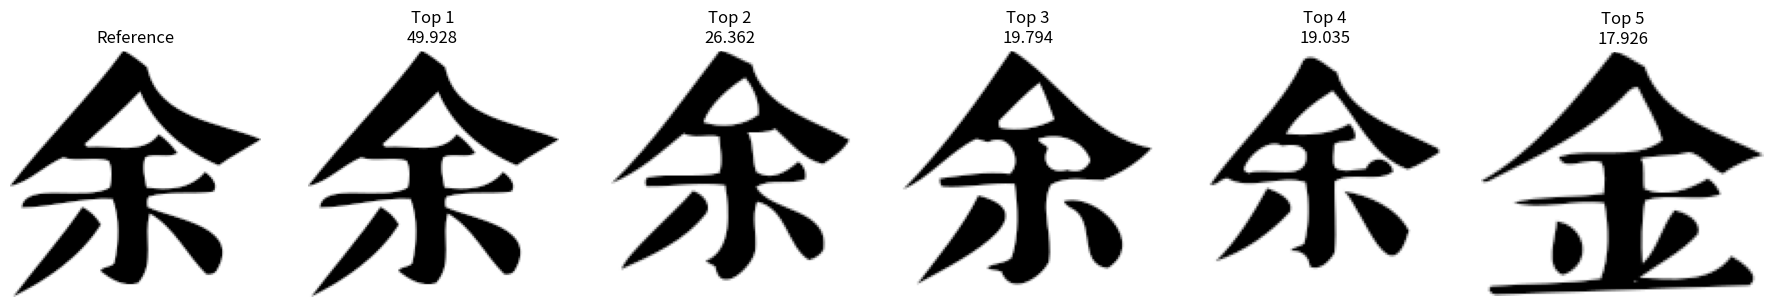

In [16]:
import matplotlib.pyplot as plt

i = np.random.randint(len(happax_df))

# i = 3

topk_result = nlfa[i].topk(k=5)
topk_best = topk_result.indices
topk_values = topk_result.values

fig, axes = plt.subplots(1, 6, figsize=(18, 3))

# Reference image
axes[0].imshow(happax_df.iloc[i]['svg'].render())
axes[0].set_title('Reference')
axes[0].axis('off')

# Top-k matches
for i, (idx, val) in enumerate(zip(topk_best, topk_values)):
    axes[i+1].imshow(repr_df['svg'].iloc[idx.item()].render())
    axes[i+1].set_title(f'Top {i+1}\n{val:.3f}')
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()

In [7]:
reg_metric = registeredMetric(metrics=metrics_dict, sym=True, lazy_metric=compute_hausdorff, lazy_threshold=24)

I1 = renderer[happax_df.index[0]]

for I2 in tqdm.tqdm(renderer):
    reg_metric(I1, I2, sym=False)

NameError: name 'happax_df' is not defined

In [ ]:
T = reg_metric.ic.run(I1.unsqueeze(0).to('cuda'), I2.unsqueeze(0).to('cuda'))
%timeit T.warp(I2.unsqueeze(0).unsqueeze(0).to('cuda'))

In [ ]:
I1.shape

In [ ]:
%%timeit
warped_bin = I2.squeeze() > 0.5
I1_bin = I1.squeeze() > 0.5

distances = {
    metric_name: metric(I1_bin, warped_bin)
    for metric_name, metric in reg_metric.metrics.items()
}


In [ ]:
%timeit reg_metric(renderer[0], renderer[1])

______

# Splitting a cluster

We successively investigate:
- Splitting via agglomerative clustering on the Haursdoff distance
- Other splitting methods
- We vary the distance - using NLFA for example

______

### Step [a]: Computing the intra-cluster distances

In [ ]:
cluster_id = 7

subdf = patches_df[patches_df['membership']  == cluster_id]

N = len(subdf)

distance_matrices = {key: np.zeros((N, N)) for key in reg_metric.metrics.keys()}

for i, j in tqdm.tqdm(np.ndindex((N, N)), total=N*N):

    i1 = subdf.index.tolist()[i]
    i2 = subdf.index.tolist()[j]

    I1 = renderer[i1]
    I2 = renderer[i2]

    if j > i and reg_metric.sym:
        continue

    metrics = reg_metric(I1, I2)

    for key in metrics:
        distance_matrices[key][i, j] = metrics[key]
        if reg_metric.sym:
            distance_matrices[key][j, i] = metrics[key]

  0%|          | 0/13456 [00:00<?, ?it/s]

 21%|██        | 2785/13456 [00:59<08:07, 21.88it/s]

In [ ]:
cluster_id = 7
subdf = patches_df[patches_df['membership'] == cluster_id]

from src.clustering.bin_image_metrics import compute_distance_matrices_batched

distance_matrices = compute_distance_matrices_batched(
    reg_metric, renderer, subdf,
    batch_size=64,   # tune: 32 for small VRAM, 128+ for large
)

Text(0, 0.5, 'Counts')

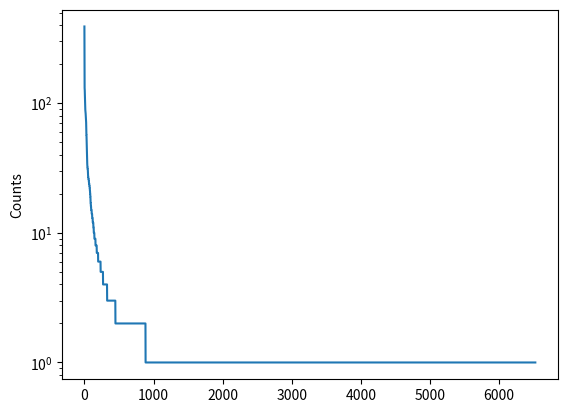

In [ ]:
_, counts = np.unique(membership, return_counts = True)

counts = counts[:]

plt.plot(np.arange(len(counts)), counts)
plt.yscale('log')

plt.ylabel('Counts')
# plt.xscale('log')

In [31]:
len(counts)

1200

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

D = distance_matrices['hausdorff']
svgs = subdf['svg']
svgs_rendered = [svg.render(scale=0.3) for svg in svgs]

condensed_D = squareform(D, checks=False)
linkage_matrix = linkage(condensed_D, method='average')

# Create LARGE figure with scrollable capability
fig, ax = plt.subplots(figsize=(max(20, len(svgs) * 0.2), 10))

dendro = dendrogram(linkage_matrix, ax=ax, no_labels=True)

leaf_indices = dendro['leaves']
leaf_x_positions = [5 + 10*i for i in range(len(leaf_indices))]

# Get y-axis limits and extend MORE to accommodate staggered images
y_min, y_max = ax.get_ylim()
image_space = (y_max - y_min) * 0.5  # Increased from 0.3 to make more room
ax.set_ylim(y_min - image_space, y_max)

# Create alternating y positions (3 levels for better spacing)
n_levels = 3  # Number of alternating levels
base_y = y_min - image_space * 0.3
level_spacing = image_space * 0.2  # Vertical spacing between levels

# Add images with LARGER zoom for readability
zoom = 0.5  # Increased from 0.3
image_annotations = []

for i, leaf_idx in enumerate(leaf_indices):
    x_pos = leaf_x_positions[i]
    
    # Alternate y position based on index
    level = i % n_levels
    y_offset = base_y - (level * level_spacing)
    
    img_array = svgs_rendered[leaf_idx]
    
    imagebox = OffsetImage(img_array, zoom=zoom, cmap='gray')
    ab = AnnotationBbox(imagebox, (x_pos, y_offset),
                        frameon=True,
                        box_alignment=(0.5, 0.5),
                        pad=0.1,
                        bboxprops=dict(edgecolor='gray', linewidth=0.5))
    ax.add_artist(ab)
    image_annotations.append(ab)
    
    # Draw a light line connecting image to its leaf position
    ax.plot([x_pos, x_pos], [y_offset + image_space*0.1, y_min], 
            color='lightgray', linewidth=0.5, linestyle=':', alpha=0.5, zorder=0)

# Threshold line
threshold_y = 21.5
threshold_line = ax.axhline(y=threshold_y, color='red', linestyle='--', 
                            linewidth=2, picker=5)

x_lim = ax.get_xlim()
cluster_text = ax.text(x_lim[1] * 0.02, threshold_y + 1, '', 
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                       fontsize=12)

def update_clusters(threshold):
    clusters = fcluster(linkage_matrix, threshold, criterion='distance')
    n_clusters = len(np.unique(clusters))
    
    cluster_text.set_text(f'{n_clusters} clusters')
    cluster_text.set_y(threshold + 1)
    
    colors = plt.cm.tab20(np.linspace(0, 1, 20))  # More colors
    
    for i, leaf_idx in enumerate(leaf_indices):
        cluster_id = clusters[leaf_idx] - 1
        color = colors[cluster_id % len(colors)]
        image_annotations[i].patch.set_edgecolor(color)
        image_annotations[i].patch.set_linewidth(3)  # Thicker borders
    
    threshold_line.set_label(f'Threshold: {threshold:.1f}')
    fig.canvas.draw_idle()

update_clusters(threshold_y)

class DraggableLine:
    def __init__(self, line, update_func):
        self.line = line
        self.update_func = update_func
        self.press = None
        self.connect()

    def connect(self):
        self.cidpress = self.line.figure.canvas.mpl_connect('button_press_event', self.on_press)
        self.cidrelease = self.line.figure.canvas.mpl_connect('button_release_event', self.on_release)
        self.cidmotion = self.line.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)

    def on_press(self, event):
        if event.inaxes != self.line.axes:
            return
        contains, attrd = self.line.contains(event)
        if not contains:
            return
        self.press = event.ydata

    def on_motion(self, event):
        if self.press is None or event.inaxes != self.line.axes:
            return
        
        y_new = event.ydata
        y_new = max(0, min(y_max, y_new))
        self.line.set_ydata([y_new, y_new])
        self.update_func(y_new)

    def on_release(self, event):
        self.press = None

draggable = DraggableLine(threshold_line, update_clusters)

ax.set_title('Hierarchical Clustering - Use pan/zoom tools below!', fontsize=14, pad=20)
ax.set_xlabel('Samples')
ax.set_ylabel('Distance')

# Enable pan and zoom toolbar
plt.tight_layout()
plt.show()

print("💡 Tip: Use the pan/zoom buttons in the toolbar to navigate the large dendrogram!")

NameError: name 'distance_matrices' is not defined

In [ ]:
%matplotlib tk

In [ ]:

patches_df['clustering_feature'] = patches_df['histogram']

min_size = 20
metric = "euclidean"

# Mean-Shift clustering
quantiles    = np.linspace(0, 1, 11)[1:-1]

# DBSCAN
db_epsilons  = np.linspace(0.5,10,10)

leiden_gammas = np.linspace(0.5, 2.0, 10)


from src.clustering.algorithms import get_algorithms

# Get all algorithms
algorithms = get_algorithms(
    quantiles=quantiles,
    db_epsilons=db_epsilons,
    leiden_gammas=leiden_gammas,
    optics_min_samples=[5, 10, 15], 
    metric=metric,
    min_size=min_size
)


In [ ]:
from src.clustering.metrics import compute_metrics

def extract_data(
    community_id,
    graph,
    dataframe
):
    node_list = list(graph.nodes())
    membership = dataframe['membership']

    node_indices = np.where(membership == community_id)[0]
    nodes_in_community = [node_list[i] for i in node_indices]
    subgraph_nx = graph.subgraph(nodes_in_community).copy()

    return dataframe.iloc[node_indices], subgraph_nx, node_indices

def evaluate_splitting_method(
    graph,
    dataframe,
    splitting_method,
    min_size            = min_size,
    membership_col_name = 'membership_split',
    character_col_name = 'char_qwen_single',
    use_tqdm=False
):
    membership = dataframe['membership']
    communities = np.unique(membership)
    if use_tqdm:
        communities = tqdm.tqdm(communities, desc="Splitting communities...", colour="magenta")

    total_communities = 0
    
    # Initialize the new column in the original dataframe
    dataframe[membership_col_name] = -1

    for community in communities:
        subdf, subgraph, node_indices = extract_data(community, graph, dataframe)

        new_membership = splitting_method(subdf, subgraph, min_size=min_size) # result MUST be of the form [|0, N-1|]
                                                                              # otherwise won't work as expected but won't crash

        unique_memberships = np.unique(new_membership)
        expected_range = np.arange(len(unique_memberships))
        assert np.array_equal(unique_memberships, expected_range), \
            f"Membership should be 0 to {len(unique_memberships)-1}, got {unique_memberships}"
        
        dataframe.loc[node_indices, membership_col_name] = new_membership + total_communities
        total_communities += len(unique_memberships)

    if use_tqdm:
        print('Computing the metrics ...')
    return compute_metrics(reference_labels=dataframe[character_col_name], predicted_labels=dataframe[membership_col_name], exclude_label=UNKNOWN_LABEL)



def test_splitting_method(
        subdf,
        subgraph
):
    return np.zeros_like(subdf['membership'])

from functools import partial
from src.clustering.algorithms import mean_shift
evaluate_splitting_method(
    graph,
    dataframe=patches_df,
    splitting_method=partial(mean_shift, q=0.3),
    membership_col_name='mean_shift_0.3',
    use_tqdm=True
)


# evaluate_splitting_method(
#     graph,
#     dataframe=patches_df,
#     splitting_method=test_splitting_method,
#     use_tqdm=True
# )

Tested algorithms:
- DBSCAN
- HDBSCAN
- Mean Shift
- Leiden
- Louvain
- Label propagation
- Greedy modularity

To be added:
- Same algorithms with different metrics
- Others?

In [ ]:
from notebook_utils.evaluate_all_splitting import evaluate_all_algorithms, generate_report

results_df, timings, failed_algos = evaluate_all_algorithms(
    graph=graph,
    dataframe=patches_df,
    algorithms=algorithms, 
    character_col_name='char_qwen_single',
    use_tqdm=True
)

# Generate complete report
figs = generate_report(results_df, output_dir='./clustering_evaluation')


In [ ]:
i = 54
subdf = patches_df[patches_df['membership'] == i] 
while len(subdf) > 30 or len(np.unique(subdf['char_qwen_single'].values)) <= 2:
    i += 1
    subdf = patches_df[patches_df['membership'] == i] 
i

In [ ]:
patches_df['char_qwen_single']

In [ ]:
from src.clustering.tsne_plot import plot_community_tsne


i = 0
subdf = patches_df[patches_df['membership'] == i] 
while len(subdf) > 30 or len(np.unique(subdf['char_qwen_single'].values)) <= 2:
    i += 1
    subdf = patches_df[patches_df['membership'] == i] 
i

cluster_id = i


# membership = label_propagation(
#     subdf=patches_df[patches_df['membership'] == cluster_id],
#     subgraph=None,
#     # q=0.2,
#     # min_size=10
# )

membership = patches_df['char_qwen_single']
# membership = patches_df['membership_leiden_gamma=0.50']

membership = membership[patches_df['membership'] == cluster_id]

print('Total number of members: ', len(membership))


unique, counts = np.unique(membership, return_counts=True)
for val, count in zip(unique, counts):
    print(f"{val}: {count}")

_ = plot_community_tsne(
    cluster_id=cluster_id,
    color_by_membership=membership,
    dataframe=patches_df,
    graph=graph,
    target_lbl='char_qwen_single',
    disable_color=False,
    disable_svg=False,
    disable_char=False,
    zoom=0.25
)

In [ ]:
import numpy as np
from tqdm import tqdm

from src.patch_processing.renderer import Renderer

def compute_distance_matrices(subdf: pd.DataFrame, renderer: Renderer, reg_metric: dict):
    """
    Compute pairwise metrics between all images in subdf.
    
    Parameters:
    -----------
    subdf : DataFrame
        Subset of patches_df with images to compare
    renderer : object
        Renderer object that can index images
    reg_metric : registeredMetric
        Initialized metric calculator
    
    Returns:
    --------
    dict : {'metric_name': X}, with X the [N, N] matrix of distances
    """
    indices = _, row1 in subdf.iterrows():subdf.index.tolist()
    n = len(indices)
    
    # Initialize metric matrices
    metric_names = list(reg_metric.metrics.keys())
    metric_matrices = {name: np.zeros((n, n)) for name in metric_names}
    
    # Compute pairwise metrics
    for i in tqdm(range(n), desc="Computing metrics"):
        for j in range(n):
            if i == j:
                # Diagonal: perfect match
                for name in metric_names:
                    if name in ['dice', 'jaccard']:
                        metric_matrices[name][i, j] = 1.0  # Perfect overlap
                    elif name == 'hamming':
                        metric_matrices[name][i, j] = 0.0  # No difference
                    elif name == 'hausdorff':
                        metric_matrices[name][i, j] = 0.0  # No distance
            else:
                # Compute metrics between different images
                I1 = renderer[indices[i]]
                I2 = renderer[indices[j]]
                
                results = reg_metric(I1, I2)
                
                for name in metric_names:
                    metric_matrices[name][i, j] = results[name]
    
    return metric_matrices


# Usage
cluster_id = 1
subdf = patches_df[patches_df['membership'] == cluster_id]



# Visualize the distance matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (metric_name, matrix) in enumerate(metric_matrices.items()):
    ax = axes[idx]
    
    # Plot heatmap
    im = ax.imshow(matrix, cmap='viridis', aspect='auto')
    ax.set_title(f'{metric_name.capitalize()} Distance Matrix', fontsize=12, fontweight='bold')
    ax.set_xlabel('Image Index')
    ax.set_ylabel('Image Index')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(metric_name, rotation=270, labelpad=20)
    

plt.tight_layout()
plt.savefig(f'metric_matrices_cluster_{cluster_id}.png', dpi=150, bbox_inches='tight')
plt.show()

# Optional: Create a combined similarity score (normalized)
def create_combined_score(metric_matrices):
    """
    Create a combined similarity score (higher = more similar).
    Normalizes all metrics to [0, 1] where 1 = most similar.
    """
    n = metric_matrices['dice'].shape[0]
    combined = np.zeros((n, n))
    
    # Dice and Jaccard: already in [0, 1], higher is better
    combined += metric_matrices['dice']
    combined += metric_matrices['jaccard']
    
    # Hamming: in [0, 1], lower is better → invert
    combined += (1 - metric_matrices['hamming'])
    
    # Hausdorff: unbounded, lower is better → normalize and invert
    hausdorff = metric_matrices['hausdorff'].copy()
    hausdorff[np.isinf(hausdorff)] = np.nan
    max_h = np.nanmax(hausdorff[~np.eye(n, dtype=bool)])
    if max_h > 0:
        hausdorff_norm = 1 - (hausdorff / max_h)
        hausdorff_norm[np.isnan(hausdorff_norm)] = 0
        combined += hausdorff_norm
    
    # Average across 4 metrics
    combined /= 4.0
    
    return combined

combined_similarity = create_combined_score(metric_matrices)

# Plot combined similarity
plt.figure(figsize=(8, 7))
plt.imshow(combined_similarity, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
plt.title('Combined Similarity Score\n(Higher = More Similar)', fontsize=14, fontweight='bold')
plt.xlabel('Image Index')
plt.ylabel('Image Index')
plt.colorbar(label='Similarity Score')
plt.tight_layout()
plt.savefig(f'combined_similarity_cluster_{cluster_id}.png', dpi=150, bbox_inches='tight')
plt.show()